# Batch Effect detection class

In [1]:
!pip -q install ./../../BatchDetect

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.


## Reading metadata

In [2]:
import pandas as pd
metadata = pd.read_csv("./../../inter-domain-hematology/metadata_stratified.csv")

indx = metadata.set0 == "test"

metadata = metadata.loc[indx,["file","label","dataset"]].reset_index(drop = True)

## Features

In [3]:
from torch.utils.data import Dataset, DataLoader
import copy
from skimage.transform import resize
from imageio import imread
import numpy as np

class DatasetGenerator(Dataset):

    def __init__(self, 
                metadata, 
                crop_size= 64  , 
                transform=None,
                selected_channels = [0]):

        self.metadata = metadata.copy().reset_index(drop = True)
        self.crop_size = crop_size
        self.transform = transform
        self.selected_channels = selected_channels

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()

        ## get image and label
        h5_file_path = self.metadata.loc[idx,"file"]
        image= imread(h5_file_path)[:,:,self.selected_channels]
        image = image / 255.
        h1 = (image.shape[0] - self.crop_size) /2
        h1 = int(h1)
        h2 = (image.shape[0] + self.crop_size) /2
        h2 = int(h2)
        
        w1 = (image.shape[1] - self.crop_size) /2
        w1 = int(w1)
        w2 = (image.shape[1] + self.crop_size) /2
        w2 = int(w2)
        image = image[h1:h2,w1:w2, :]
        image = np.transpose(image, (2, 0, 1))
        label = self.metadata.loc[idx,"label"]
 
        # map numpy array to tensor
        image = torch.from_numpy(copy.deepcopy(image)) 
        image = image.float()
        
        if self.transform:
            image = self.transform(image) 
        return image.float(), label, idx

In [4]:
X_features = pd.DataFrame(index = metadata.index, columns = ["X" + str(i+1) for i in range(512) ])

In [5]:
selected_channels = [0,1,2]
from torchvision.models import resnet18
from torchvision import transforms
import torch
import torch.nn as nn
import tqdm

feature_extractor = nn.Sequential(*list(resnet18(pretrained = True).children())[:-1])
feature_extractor.eval()
transform = transforms.Compose([
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225]) # from imagenet
    ])


dataset_image_size = {
    "Ace_20":250,   #250,
    "Ace_20b":250,   #250,
    "Mat_19":345,   #345, 
    "MLL_20":288,   #288,  
}

for ds in  metadata["dataset"].unique():
    print(ds)
    dataset_index = metadata["dataset"] == ds
    dataset_index = dataset_index[dataset_index].index
    dataset = DatasetGenerator(    metadata.loc[dataset_index,:],
                                   dataset_image_size[ds],
                                   transform,
                                   selected_channels)
    
    dataloader =  DataLoader(dataset, 
                         batch_size=64,
                         shuffle=False, 
                         num_workers=4)
    
    with torch.no_grad():
        for data in dataloader: 
            idx = data[2].cpu().numpy()  
            inputs = data[0].cpu()
            inputs = inputs.float()
            features = feature_extractor(inputs).numpy().reshape((len(idx),512))
            X_features.loc[dataset_index[idx],:] = features
    dataset = None
    del dataset
    dataloader = None
    del dataloader

feature_extractor = None

Ace_20
Ace_20b
Mat_19
MLL_20


## Let's see if there is a batch effect in the data

In [6]:
from batchdetect.batchdetect import BatchDetect

bd = BatchDetect(metadata.loc[:,["label","dataset"]], X_features)

# visualizations

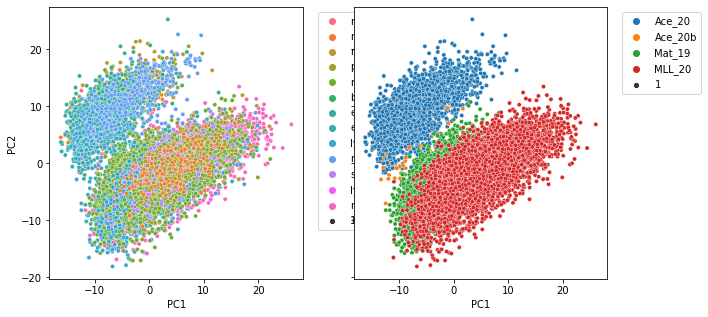

In [7]:
bd.low_dim_visualization("pca")

/home/icb/sayedali.boushehri/miniconda3/envs/py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/icb/sayedali.boushehri/miniconda3/envs/py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


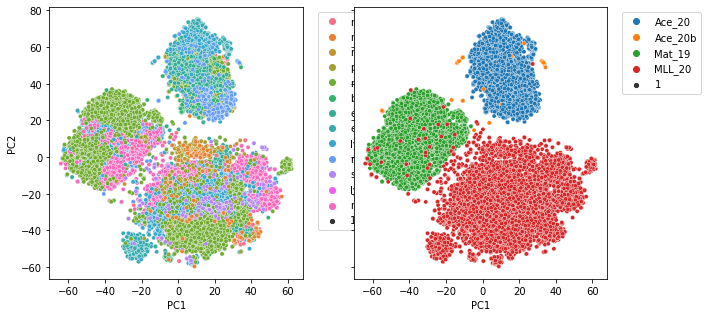

In [8]:
bd.low_dim_visualization("tsne")

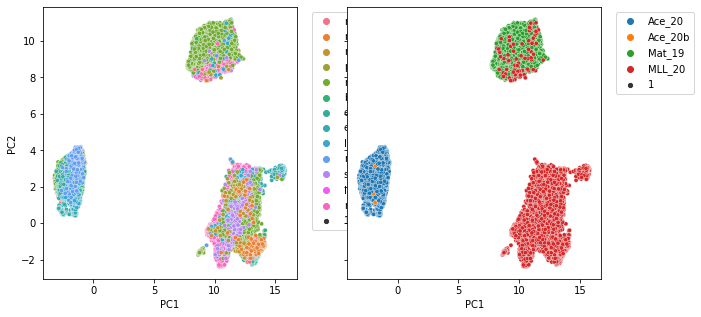

In [9]:
bd.low_dim_visualization("umap")

# Anova test of principal components vs. labels

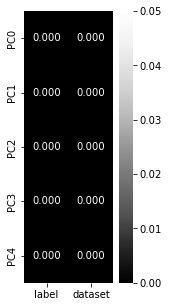

In [10]:
bd.prince_plot()

## classification test of  RF vs a random classifier

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   12.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  6.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    9.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  5.2min finished


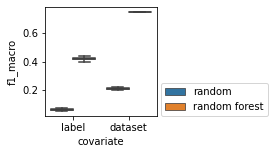

In [11]:
bd.classification_test(scorer="f1_macro")